In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mpl
import seaborn as sea
import warnings
import datetime as dt
from sklearn.impute import SimpleImputer as skimpute
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2
from sklearn.preprocessing import KBinsDiscretizer as Discretizer

In [91]:
dataFrame = pd.read_csv("marketing_campaign.csv", sep = ";")

In [92]:
dataFrame.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [93]:
dataFrame.shape

(2240, 29)

In [94]:
pd.set_option("display.max_columns", None)

In [95]:
warnings.filterwarnings("ignore")

In [96]:
dataFrame = dataFrame.drop(["ID"], axis = 1)

In [97]:
dataFrame.shape

(2240, 28)

In [98]:
y = dataFrame[["Response"]]
x = dataFrame.drop(["Response"], axis = 1)

In [99]:
y.shape

(2240, 1)

In [100]:
x.shape

(2240, 27)

In [101]:
y.mean()

Response    0.149107
dtype: float64

In [102]:
reference_date = dt.datetime(2024, 5, 1)
print(reference_date)

2024-05-01 00:00:00


In [103]:
#convert year of birth to age, convert dt customer to time span of user being registered customer
x["Year_Birth"] = pd.to_datetime(dataFrame["Year_Birth"], format="%Y")
x["Age"] = round((reference_date - x["Year_Birth"]).dt.days / 365, 0)
x["Dt_Customer"] = pd.to_datetime(x["Dt_Customer"])
x["Customer_Tenure"] = round((reference_date - x["Dt_Customer"]).dt.days / 365, 0)

#x = x.drop(["Year_Birth", "Dt_Customer"], axis = 1)

In [104]:
x[["Age", "Customer_Tenure"]].head()

,Age,Customer_Tenure
0,67.0,12.0
1,70.0,10.0
2,59.0,11.0
3,40.0,10.0
4,43.0,10.0


In [105]:
x = x.drop(["Year_Birth", "Dt_Customer"], axis = 1)

In [106]:
dataFrame.dtypes

Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object

In [107]:
#split features to categorical and numerical
numerical = x.select_dtypes(include = "number")
categorical = x.select_dtypes(include = "object")

In [108]:
def uniqueness(x):
    x = x.value_counts().count()
    return x
df_value_counts = pd.DataFrame(numerical.apply(lambda x: uniqueness(x)))

In [109]:
df_value_counts.columns = ["feature_levels"]

In [110]:
df_value_counts.head()

,feature_levels
Income,1974
Kidhome,3
Teenhome,3
Recency,100
MntWines,776


In [111]:
featuresWithLessThan20levels = df_value_counts.loc[df_value_counts["feature_levels"] <= 20]
categorical_list = featuresWithLessThan20levels.index
categorical_features_from_numerical = numerical.loc[:, categorical_list]
categorical_features_from_numerical.dtypes

Kidhome                  int64
Teenhome                 int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Customer_Tenure        float64
dtype: object

In [112]:
def convert_type(x, convert_to_type):
    x = x.astype(convert_to_type)
    return x
categorical_features_from_numerical = categorical_features_from_numerical.apply(lambda x : convert_type(x, "object"))
categorical_features_from_numerical.dtypes

Kidhome                object
Teenhome               object
NumDealsPurchases      object
NumWebPurchases        object
NumCatalogPurchases    object
NumStorePurchases      object
NumWebVisitsMonth      object
AcceptedCmp3           object
AcceptedCmp4           object
AcceptedCmp5           object
AcceptedCmp1           object
AcceptedCmp2           object
Complain               object
Z_CostContact          object
Z_Revenue              object
Customer_Tenure        object
dtype: object

In [113]:
featuresWithMoreThan20levels = df_value_counts.loc[df_value_counts["feature_levels"] > 20]
numerical_list = featuresWithMoreThan20levels.index
numerical = numerical.loc[:, numerical_list]

In [114]:
categorical = pd.concat([categorical, categorical_features_from_numerical], axis = 1, join = "inner")

In [115]:
numerical.shape

(2240, 9)

In [116]:
categorical.shape

(2240, 18)

In [117]:
def cap_outliers(x):
    x = x.clip(lower = x.quantile(0.01))
    x = x.clip(upper = x.quantile(0.99))
    return x
numerical = numerical.apply(lambda x: cap_outliers(x))

In [118]:
numerical.describe(percentiles=[0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.85, 0.9, 0.99])

,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,Age
count,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,51770.277076,49.101786,302.909821,26.158482,165.075446,37.351366,26.873687,43.770089,55.132143
std,20728.704775,28.949501,333.316827,39.208270,216.547373,53.985910,40.484302,51.118104,11.666094
min,7579.200000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,32.000000
1%,7646.520000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,32.000000
5%,18985.500000,4.000000,3.000000,0.000000,4.000000,0.000000,0.000000,1.000000,36.000000
10%,24117.500000,9.000000,6.000000,0.000000,7.000000,0.000000,0.000000,3.000000,40.000000
25%,35303.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,47.000000
50%,51381.500000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,54.000000
75%,68522.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,65.000000


In [119]:
#check missing val
numerical.isnull().mean()

Income              0.010714
Recency             0.000000
MntWines            0.000000
MntFruits           0.000000
MntMeatProducts     0.000000
MntFishProducts     0.000000
MntSweetProducts    0.000000
MntGoldProds        0.000000
Age                 0.000000
dtype: float64

In [120]:
imputer = skimpute(missing_values = np.nan, strategy="mean")
numerical_imputed = pd.DataFrame(imputer.fit_transform(numerical), index = numerical.index, columns = numerical.columns)

In [121]:
numerical_imputed.isnull().mean()

Income              0.0
Recency             0.0
MntWines            0.0
MntFruits           0.0
MntMeatProducts     0.0
MntFishProducts     0.0
MntSweetProducts    0.0
MntGoldProds        0.0
Age                 0.0
dtype: float64

In [122]:
#check missing values for categorical
categorical.isnull().mean()

Education              0.0
Marital_Status         0.0
Kidhome                0.0
Teenhome               0.0
NumDealsPurchases      0.0
NumWebPurchases        0.0
NumCatalogPurchases    0.0
NumStorePurchases      0.0
NumWebVisitsMonth      0.0
AcceptedCmp3           0.0
AcceptedCmp4           0.0
AcceptedCmp5           0.0
AcceptedCmp1           0.0
AcceptedCmp2           0.0
Complain               0.0
Z_CostContact          0.0
Z_Revenue              0.0
Customer_Tenure        0.0
dtype: float64

In [123]:
#check variance
variance = VarianceThreshold(threshold=0)
variance.fit_transform(numerical_imputed)
affected_columns = variance.get_support(indices = True)
numerical_imputed_variance_checked = numerical_imputed.iloc[:, affected_columns]

In [124]:
numerical_imputed_variance_checked.head()

,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,Age
0,58138.0,58.0,635.0,88.0,546.0,172.0,88.0,88.0,67.0
1,46344.0,38.0,11.0,1.0,6.0,2.0,1.0,6.0,70.0
2,71613.0,26.0,426.0,49.0,127.0,111.0,21.0,42.0,59.0
3,26646.0,26.0,11.0,4.0,20.0,10.0,3.0,5.0,40.0
4,58293.0,94.0,173.0,43.0,118.0,46.0,27.0,15.0,43.0


In [125]:
#feature discretization
discretizer = Discretizer(n_bins=10, encode = "ordinal", strategy = "quantile")
numerical_binned = pd.DataFrame(discretizer.fit_transform(numerical_imputed_variance_checked), index = numerical_imputed_variance_checked.index, columns = numerical_imputed_variance_checked.columns).add_suffix("_Discrete")
numerical_binned.head()

,Income_Discrete,Recency_Discrete,MntWines_Discrete,MntFruits_Discrete,MntMeatProducts_Discrete,MntFishProducts_Discrete,MntSweetProducts_Discrete,MntGoldProds_Discrete,Age_Discrete
0,5.0,5.0,8.0,8.0,9.0,8.0,7.0,8.0,8.0
1,4.0,3.0,1.0,1.0,0.0,1.0,1.0,2.0,8.0
2,7.0,2.0,7.0,7.0,6.0,7.0,5.0,6.0,6.0
3,1.0,2.0,1.0,3.0,3.0,3.0,2.0,1.0,1.0
4,6.0,9.0,4.0,6.0,6.0,6.0,6.0,3.0,1.0


In [126]:
x_binned_combined = pd.concat([y, numerical_binned], axis = 1, join = "inner")

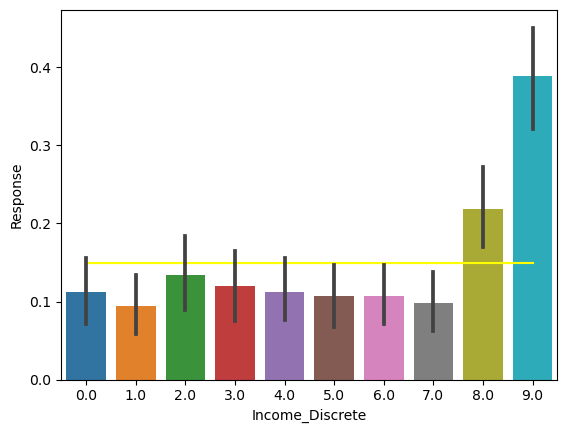

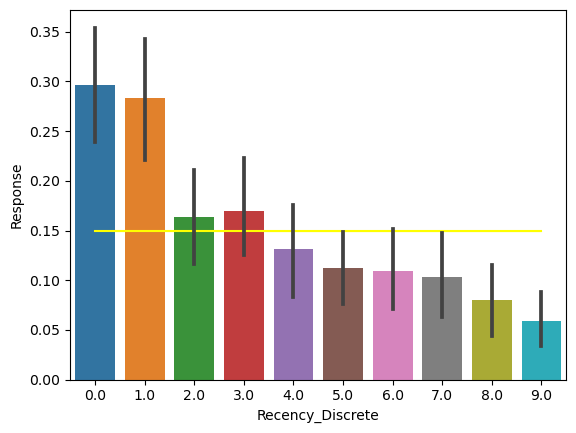

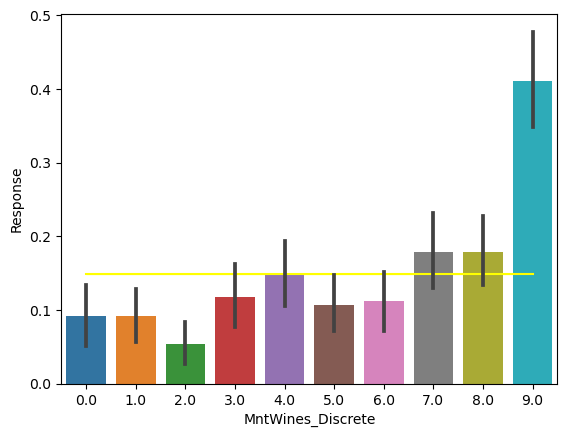

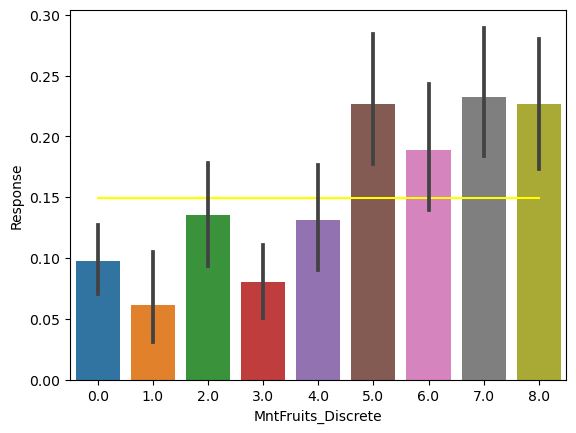

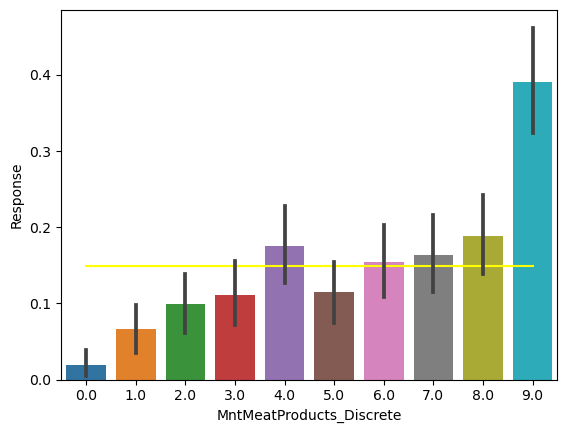

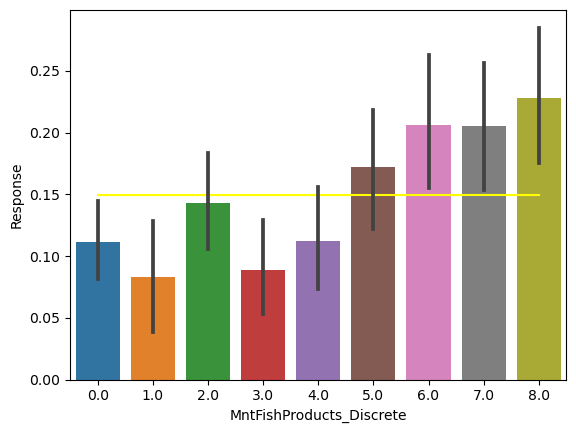

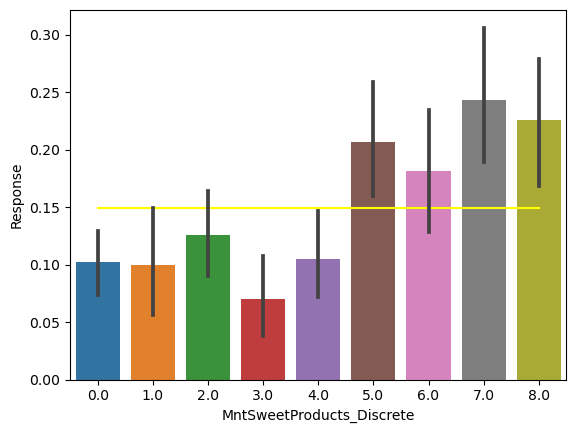

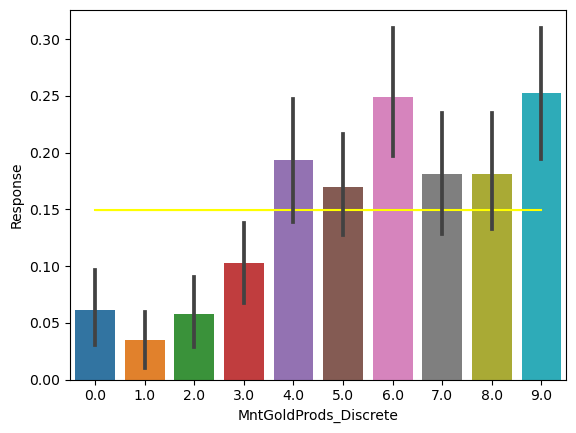

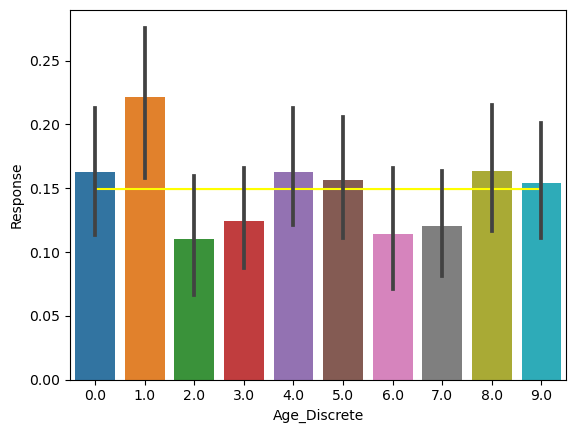

In [127]:
#check correlation for every col regarding to target var
from numpy import mean
for column in numerical_binned.columns:
    mpl.figure()
    sea.lineplot(x = column, y = x_binned_combined["Response"].mean(), data = x_binned_combined, color="yellow")
    sea.barplot(x = column, y = "Response", data = x_binned_combined, estimator = mean)
mpl.show()

In [128]:
numerical_imputed_variance_checked = numerical_imputed_variance_checked.drop(["Age"], axis = 1)
numerical_imputed_variance_checked.shape

(2240, 8)

In [129]:
numerical_imputed_variance_checked.head()

,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds
0,58138.0,58.0,635.0,88.0,546.0,172.0,88.0,88.0
1,46344.0,38.0,11.0,1.0,6.0,2.0,1.0,6.0
2,71613.0,26.0,426.0,49.0,127.0,111.0,21.0,42.0
3,26646.0,26.0,11.0,4.0,20.0,10.0,3.0,5.0
4,58293.0,94.0,173.0,43.0,118.0,46.0,27.0,15.0


In [130]:
#select 6 best features
selector = SelectKBest(chi2, k = 6)
selector.fit_transform(numerical_imputed_variance_checked, y)
columns = selector.get_support(indices = True)
selected_numerical_features = numerical_imputed.iloc[:, columns]
selected_numerical_features.iloc[0]

Income             58138.0
MntWines             635.0
MntFruits             88.0
MntMeatProducts      546.0
MntFishProducts      172.0
MntGoldProds          88.0
Name: 0, dtype: float64

In [131]:
#categorical features selection
categorical_features_uniqueness = pd.DataFrame(categorical.apply(lambda x: uniqueness(x)))

In [132]:
categorical_features_uniqueness

,0
Education,5
Marital_Status,8
Kidhome,3
Teenhome,3
NumDealsPurchases,15
NumWebPurchases,15
NumCatalogPurchases,14
NumStorePurchases,14
NumWebVisitsMonth,16
AcceptedCmp3,2


In [133]:
categorical_features_uniqueness.columns=["feature_levels"]
categorical_features_uniqueness_slice = categorical_features_uniqueness.loc[categorical_features_uniqueness["feature_levels"] > 1]
sliced_list = categorical_features_uniqueness_slice.index
categorical = categorical.loc[:, sliced_list]

In [134]:
categorical

,Education,Marital_Status,Kidhome,Teenhome,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Customer_Tenure
0,Graduation,Single,0,0,3,8,10,4,7,0,0,0,0,0,0,12.0
1,Graduation,Single,1,1,2,1,1,2,5,0,0,0,0,0,0,10.0
2,Graduation,Together,0,0,1,8,2,10,4,0,0,0,0,0,0,11.0
3,Graduation,Together,1,0,2,2,0,4,6,0,0,0,0,0,0,10.0
4,PhD,Married,1,0,5,5,3,6,5,0,0,0,0,0,0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,Graduation,Married,0,1,2,9,3,4,5,0,0,0,0,0,0,11.0
2236,PhD,Together,2,1,7,8,2,5,7,0,0,0,1,0,0,10.0
2237,Graduation,Divorced,0,0,1,2,3,13,6,0,1,0,0,0,0,10.0
2238,Master,Together,0,1,2,6,5,10,3,0,0,0,0,0,0,10.0


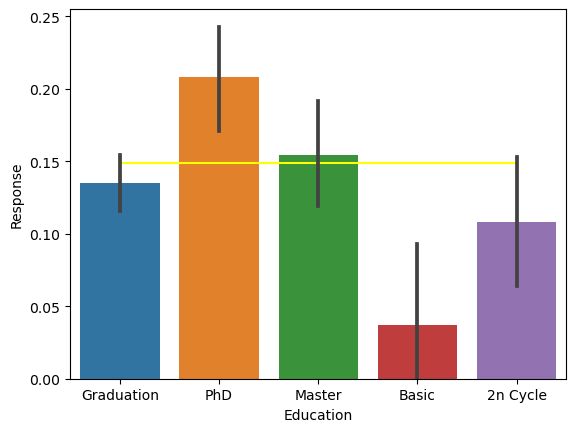

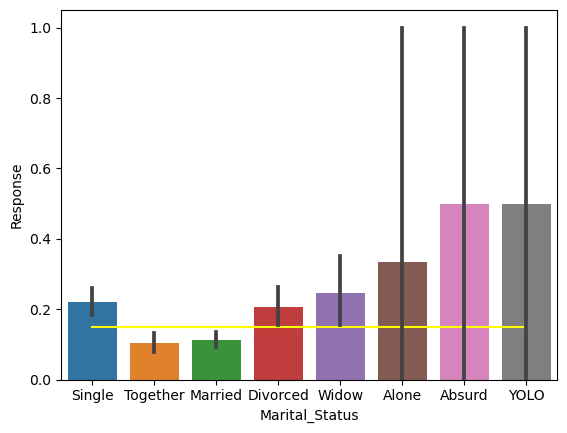

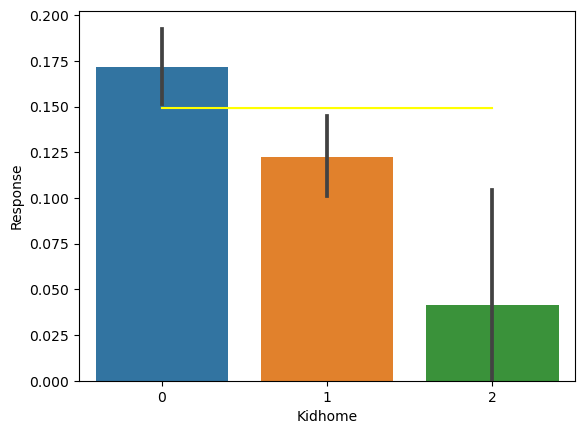

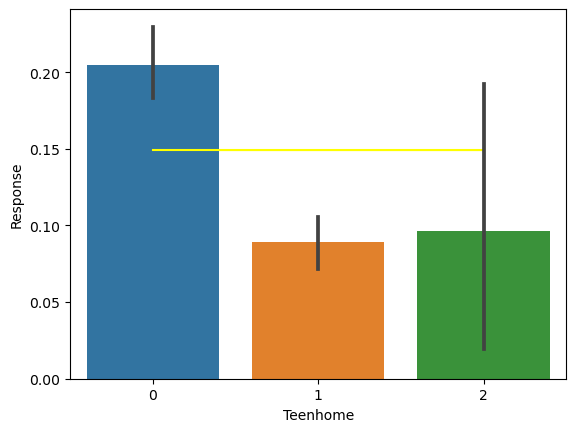

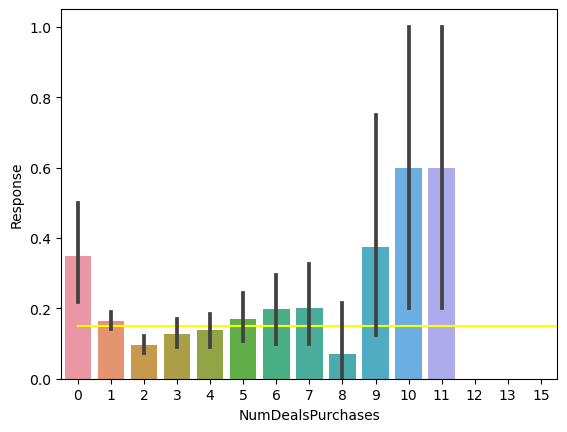

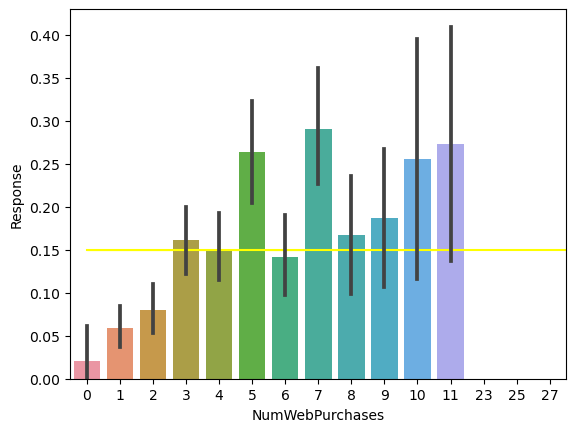

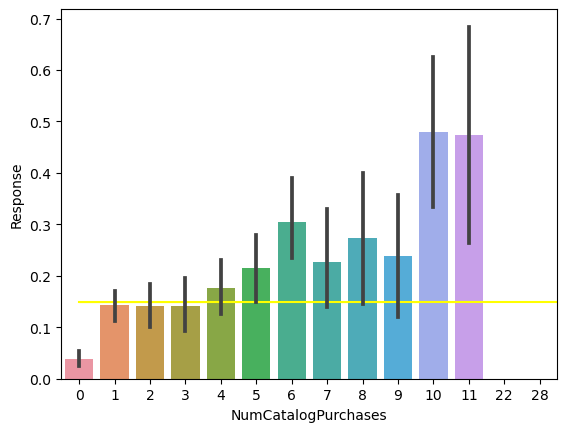

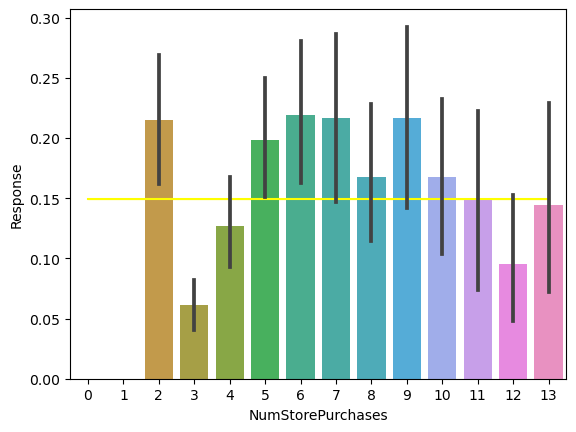

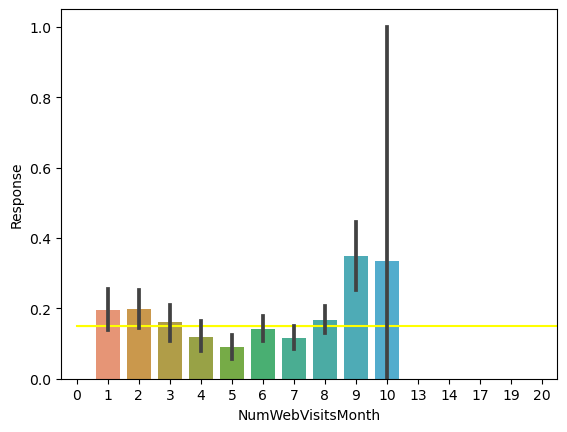

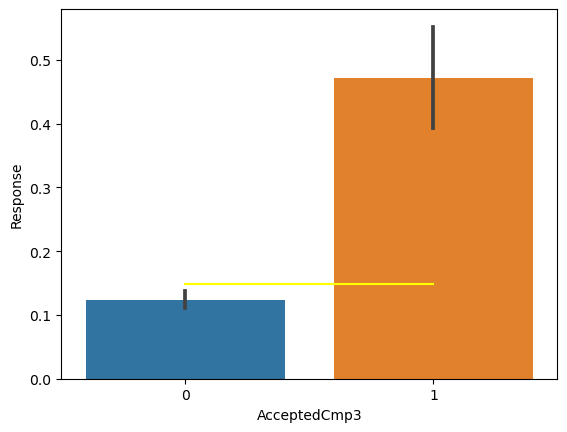

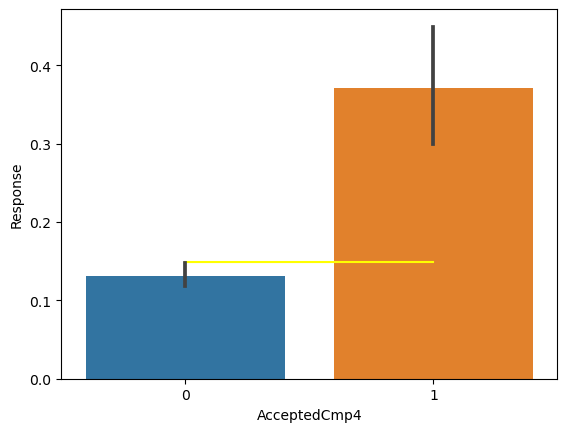

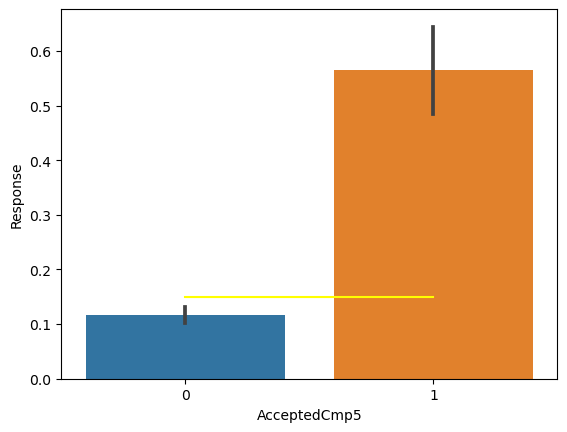

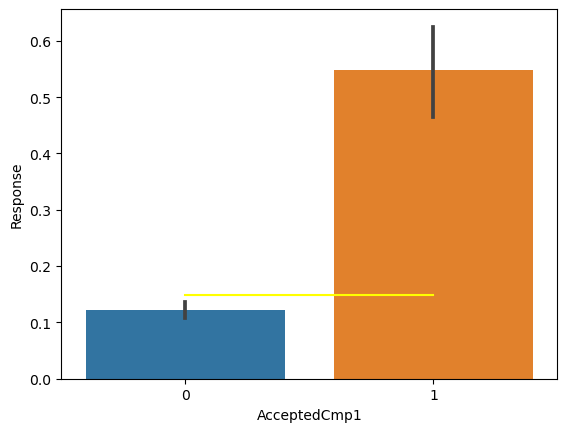

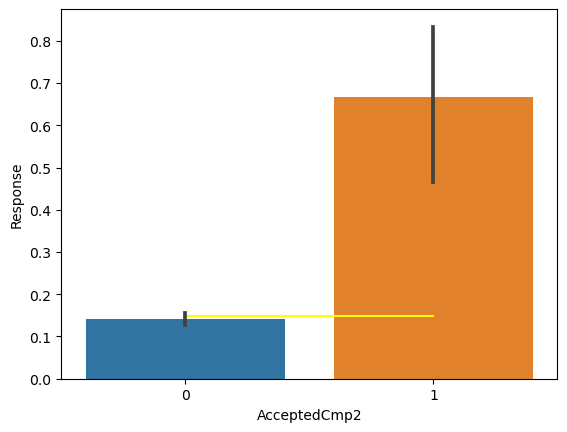

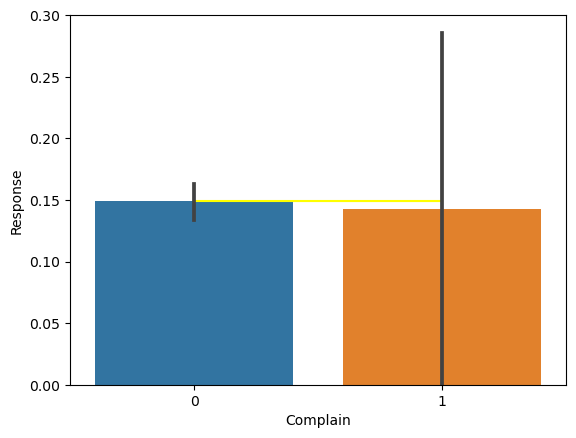

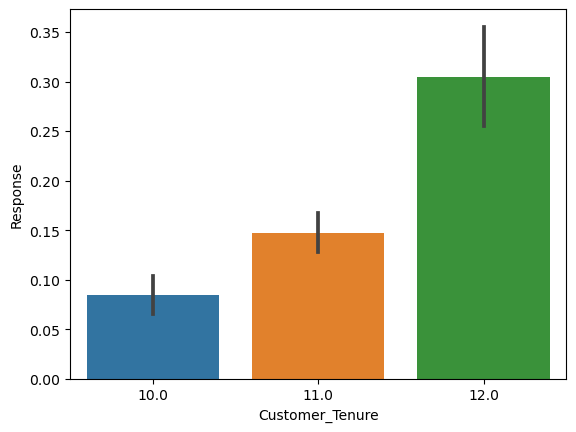

In [135]:
#check correlation for every col regarding to target var
x_categorical_merged = pd.concat([y, categorical], axis = 1, join = "inner")

from numpy import mean
for col in categorical.columns:
    mpl.figure()
    sea.lineplot(x = col, y = x_categorical_merged["Response"].mean(), data = x_categorical_merged, color = "yellow")
    sea.barplot(x = col, y = "Response", data = x_categorical_merged, estimator = mean)
mpl.show()

In [136]:
categorical_list_drop = ["Education", "NumStorePurchases", "Complain"]
categorical = categorical.drop(categorical_list_drop, axis = 1)
categorical.shape

(2240, 13)

In [137]:
#creating dummy features (n-1), decompose to simple col values
x_categorical_dummies = pd.get_dummies(categorical, drop_first = True)
x_categorical_dummies.shape

(2240, 74)

In [138]:
x_categorical_dummies.head()

,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO,Kidhome_1,Kidhome_2,Teenhome_1,Teenhome_2,NumDealsPurchases_1,NumDealsPurchases_2,NumDealsPurchases_3,NumDealsPurchases_4,NumDealsPurchases_5,NumDealsPurchases_6,NumDealsPurchases_7,NumDealsPurchases_8,NumDealsPurchases_9,NumDealsPurchases_10,NumDealsPurchases_11,NumDealsPurchases_12,NumDealsPurchases_13,NumDealsPurchases_15,NumWebPurchases_1,NumWebPurchases_2,NumWebPurchases_3,NumWebPurchases_4,NumWebPurchases_5,NumWebPurchases_6,NumWebPurchases_7,NumWebPurchases_8,NumWebPurchases_9,NumWebPurchases_10,NumWebPurchases_11,NumWebPurchases_23,NumWebPurchases_25,NumWebPurchases_27,NumCatalogPurchases_1,NumCatalogPurchases_2,NumCatalogPurchases_3,NumCatalogPurchases_4,NumCatalogPurchases_5,NumCatalogPurchases_6,NumCatalogPurchases_7,NumCatalogPurchases_8,NumCatalogPurchases_9,NumCatalogPurchases_10,NumCatalogPurchases_11,NumCatalogPurchases_22,NumCatalogPurchases_28,NumWebVisitsMonth_1,NumWebVisitsMonth_2,NumWebVisitsMonth_3,NumWebVisitsMonth_4,NumWebVisitsMonth_5,NumWebVisitsMonth_6,NumWebVisitsMonth_7,NumWebVisitsMonth_8,NumWebVisitsMonth_9,NumWebVisitsMonth_10,NumWebVisitsMonth_13,NumWebVisitsMonth_14,NumWebVisitsMonth_17,NumWebVisitsMonth_19,NumWebVisitsMonth_20,AcceptedCmp3_1,AcceptedCmp4_1,AcceptedCmp5_1,AcceptedCmp1_1,AcceptedCmp2_1,Customer_Tenure_11.0,Customer_Tenure_12.0
0,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1,False,False,False,True,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [139]:
selector = SelectKBest(chi2, k = 70)
selector.fit_transform(x_categorical_dummies, y)

#get indexes of col to keep
columns = selector.get_support(indices = True)
selected_categorical_features = x_categorical_dummies.iloc[:, columns]

In [140]:
selected_categorical_features.dtypes

Marital_Status_Alone       bool
Marital_Status_Divorced    bool
Marital_Status_Married     bool
Marital_Status_Single      bool
Marital_Status_Together    bool
                           ... 
AcceptedCmp4_1             bool
AcceptedCmp5_1             bool
AcceptedCmp1_1             bool
AcceptedCmp2_1             bool
Customer_Tenure_12.0       bool
Length: 70, dtype: object

In [141]:
#join selected numerical and categorical features
x_all_features = pd.concat([selected_categorical_features, selected_numerical_features], axis = 1, join = "inner")

In [142]:
x_all_features.head()

,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO,Kidhome_1,Kidhome_2,Teenhome_1,Teenhome_2,NumDealsPurchases_1,NumDealsPurchases_2,NumDealsPurchases_3,NumDealsPurchases_4,NumDealsPurchases_5,NumDealsPurchases_6,NumDealsPurchases_7,NumDealsPurchases_8,NumDealsPurchases_9,NumDealsPurchases_10,NumDealsPurchases_11,NumDealsPurchases_12,NumDealsPurchases_13,NumDealsPurchases_15,NumWebPurchases_1,NumWebPurchases_2,NumWebPurchases_3,NumWebPurchases_5,NumWebPurchases_7,NumWebPurchases_8,NumWebPurchases_9,NumWebPurchases_10,NumWebPurchases_11,NumWebPurchases_23,NumWebPurchases_25,NumWebPurchases_27,NumCatalogPurchases_1,NumCatalogPurchases_2,NumCatalogPurchases_4,NumCatalogPurchases_5,NumCatalogPurchases_6,NumCatalogPurchases_7,NumCatalogPurchases_8,NumCatalogPurchases_9,NumCatalogPurchases_10,NumCatalogPurchases_11,NumCatalogPurchases_22,NumCatalogPurchases_28,NumWebVisitsMonth_1,NumWebVisitsMonth_2,NumWebVisitsMonth_3,NumWebVisitsMonth_4,NumWebVisitsMonth_5,NumWebVisitsMonth_6,NumWebVisitsMonth_7,NumWebVisitsMonth_8,NumWebVisitsMonth_9,NumWebVisitsMonth_10,NumWebVisitsMonth_13,NumWebVisitsMonth_14,NumWebVisitsMonth_17,NumWebVisitsMonth_19,NumWebVisitsMonth_20,AcceptedCmp3_1,AcceptedCmp4_1,AcceptedCmp5_1,AcceptedCmp1_1,AcceptedCmp2_1,Customer_Tenure_12.0,Income,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntGoldProds
0,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,58138.0,635.0,88.0,546.0,172.0,88.0
1,False,False,False,True,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,46344.0,11.0,1.0,6.0,2.0,6.0
2,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,71613.0,426.0,49.0,127.0,111.0,42.0
3,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,26646.0,11.0,4.0,20.0,10.0,5.0
4,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,58293.0,173.0,43.0,118.0,46.0,15.0


In [143]:
for column in x_all_features.columns:
    if x_all_features[column].dtype == 'float64':
        x_all_features[column] = x_all_features[column].astype(np.float32)

In [144]:
for column in x_all_features.columns:
    if x_all_features[column].dtype == 'bool':
        x_all_features[column] = x_all_features[column].astype(np.uint8)

In [145]:
x_all_features.dtypes

Marital_Status_Alone         uint8
Marital_Status_Divorced      uint8
Marital_Status_Married       uint8
Marital_Status_Single        uint8
Marital_Status_Together      uint8
                            ...   
MntWines                   float32
MntFruits                  float32
MntMeatProducts            float32
MntFishProducts            float32
MntGoldProds               float32
Length: 76, dtype: object

In [146]:
from varclushi import VarClusHi

var_clus = VarClusHi(x_all_features, maxeigval2=1, maxclus=None)
var_clus.varclus()

In [147]:
var_clus.info

,Cluster,N_Vars,Eigval1,Eigval2,VarProp
0,0,8,4.016371,0.961196,0.502046
1,1,3,1.590210,0.835650,0.530070
2,2,4,1.832339,0.887457,0.458085
3,3,2,1.533925,0.466075,0.766963
4,4,3,1.470022,0.998583,0.490007
5,5,3,1.198027,0.944812,0.399342
6,6,4,1.187873,0.999723,0.296968
7,7,3,1.201906,0.958295,0.400635
8,8,3,1.217840,0.992642,0.405947
9,9,3,1.054046,0.998560,0.351349


In [148]:
check_clusters = var_clus.rsquare
check_clusters

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio
0,0,Kidhome_1,0.438819,0.076622,0.607749
1,0,Income,0.736300,0.168487,0.317133
2,0,MntWines,0.593854,0.274441,0.559769
3,0,MntFruits,0.540704,0.081939,0.500290
4,0,MntMeatProducts,0.691833,0.156511,0.365347
...,...,...,...,...,...
71,31,NumWebVisitsMonth_5,0.340537,0.018102,0.671621
72,31,NumCatalogPurchases_28,0.259318,0.061472,0.789196
73,31,NumWebVisitsMonth_1,0.541568,0.116654,0.518973
74,32,NumWebPurchases_25,1.000000,0.002924,0.000000


In [149]:
filtered = check_clusters[check_clusters["RS_Ratio"] <= 0.5]
filtered.shape

(39, 5)

In [150]:
filtered.head()

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio
1,0,Income,0.736300,0.168487,0.317133
4,0,MntMeatProducts,0.691833,0.156511,0.365347
5,0,MntFishProducts,0.574333,0.108486,0.477465
8,1,Teenhome_1,0.576538,0.049532,0.445530
9,1,NumDealsPurchases_1,0.649819,0.044876,0.366634


In [151]:
final_features = filtered["Variable"]
x_all_features = x_all_features[final_features]
x_all_features.shape

(2240, 39)

In [152]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_all_features, y, test_size = 0.3, random_state = 20)

In [153]:
x_train.shape

(1568, 39)

In [154]:
x_test.shape

(672, 39)

In [155]:
#logic regression model
from sklearn.linear_model import LogisticRegression
log_regression = LogisticRegression(random_state = 20)
log_regression.fit(x_train, y_train)

LogisticRegression(random_state=20)

In [156]:
#decision tree
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion = "gini", random_state = 20)

In [157]:
#determine best parameters for tree
from sklearn.model_selection import GridSearchCV
param_options = { "max_depth" : [3, 5, 6, 7], "min_samples_split" : [75, 100, 125, 150] }
grid_search = GridSearchCV(tree, cv = 10, param_grid = param_options, n_jobs = 3)
grid_search.fit(x_train, y_train)
grid_search.best_params_

{'max_depth': 3, 'min_samples_split': 125}

In [158]:
tree = DecisionTreeClassifier(criterion = "gini", random_state = 20, max_depth = 3, min_samples_split = 125)
tree.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_split=125, random_state=20)

In [159]:
#random tree forest
from sklearn.ensemble import RandomForestClassifier
rand_forest = RandomForestClassifier(criterion = "gini", random_state = 20, max_depth = 3, min_samples_split = 125)
rand_forest.fit(x_train, y_train)

RandomForestClassifier(max_depth=3, min_samples_split=125, random_state=20)

In [160]:
#gradient boost
from sklearn.ensemble import GradientBoostingClassifier
grad_boost = GradientBoostingClassifier(criterion = "friedman_mse", random_state = 20, max_depth = 3, min_samples_split = 125)
grad_boost.fit(x_train, y_train)

GradientBoostingClassifier(min_samples_split=125, random_state=20)

In [161]:
from sklearn import metrics
y_predict_logistic_regression = log_regression.predict(x_test)
y_predict_tree = tree.predict(x_test)
y_predict_rand_forest = rand_forest.predict(x_test)
y_predict_grad_boost = grad_boost.predict(x_test)

In [162]:
print("Logistic reg accuracy", metrics.accuracy_score(y_test, y_predict_logistic_regression))
print("Logistic reg precision", metrics.precision_score(y_test, y_predict_logistic_regression))
print("Logistic reg recall score", metrics.recall_score(y_test, y_predict_logistic_regression))
print("Logistic reg f1 score", metrics.f1_score(y_test, y_predict_logistic_regression))

Logistic reg accuracy 0.8511904761904762
Logistic reg precision 0.45454545454545453
Logistic reg recall score 0.050505050505050504
Logistic reg f1 score 0.0909090909090909


In [163]:
print("Tree accuracy", metrics.accuracy_score(y_test, y_predict_tree))
print("Tree precision", metrics.precision_score(y_test, y_predict_tree))
print("Tree recall score", metrics.recall_score(y_test, y_predict_tree))
print("Tree f1 score", metrics.f1_score(y_test, y_predict_tree))

Tree accuracy 0.8526785714285714
Tree precision 0.0
Tree recall score 0.0
Tree f1 score 0.0


In [164]:
print("rand_forest accuracy", metrics.accuracy_score(y_test, y_predict_rand_forest))
print("rand_forest precision", metrics.precision_score(y_test, y_predict_rand_forest))
print("rand_forest recall score", metrics.recall_score(y_test, y_predict_rand_forest))
print("rand_forest f1 score", metrics.f1_score(y_test, y_predict_rand_forest))

rand_forest accuracy 0.8526785714285714
rand_forest precision 0.0
rand_forest recall score 0.0
rand_forest f1 score 0.0


In [165]:
print("grad_boost accuracy", metrics.accuracy_score(y_test, y_predict_grad_boost))
print("grad_boost precision", metrics.precision_score(y_test, y_predict_grad_boost))
print("grad_boost recall score", metrics.recall_score(y_test, y_predict_grad_boost))
print("grad_boost f1 score", metrics.f1_score(y_test, y_predict_grad_boost))

grad_boost accuracy 0.8616071428571429
grad_boost precision 0.5833333333333334
grad_boost recall score 0.21212121212121213
grad_boost f1 score 0.3111111111111111


In [166]:
feature_importance = pd.DataFrame(grad_boost.feature_importances_,
                                  index = x_train.columns, 
                                  columns = ['importance']).sort_values('importance', ascending = False)

In [167]:
feature_importance.shape

(39, 1)

In [168]:
feature_importance.iloc[0:10]

,importance
Income,0.246452
MntMeatProducts,0.220739
AcceptedCmp3_1,0.184007
MntFishProducts,0.060875
NumWebVisitsMonth_9,0.047260
NumCatalogPurchases_10,0.035619
NumDealsPurchases_10,0.023986
Marital_Status_Together,0.023061
Marital_Status_Single,0.022048
Marital_Status_Widow,0.020091


In [169]:
#get probabilities
y_predicted_probabilites = grad_boost.predict_proba(x_all_features)[:, 1]
dataFrame['predicted_prob'] = pd.DataFrame(y_predicted_probabilites)

In [170]:
#create deciles
dataFrame['P_Rank_gradBoost'] = pd.qcut(dataFrame['predicted_prob'].rank(method = 'first').values, 10, duplicates = 'drop').codes + 1
dataFrame[['predicted_prob', 'P_Rank_gradBoost']].head()

,predicted_prob,P_Rank_gradBoost
0,0.627543,10
1,0.028867,1
2,0.068755,4
3,0.044883,2
4,0.060537,4


In [171]:
ranked_dataFrame = dataFrame.groupby('P_Rank_gradBoost')['Response'].agg(['count', 'mean']).sort_values(by = 'P_Rank_gradBoost', ascending = False)
ranked_dataFrame.rename(columns = {'mean': 'Actual_event_rate'}, inplace = True)
ranked_dataFrame

,count,Actual_event_rate
P_Rank_gradBoost,,
10,224,0.687500
9,224,0.312500
8,224,0.200893
7,224,0.071429
6,224,0.075893
5,224,0.058036
4,224,0.026786
3,224,0.040179
2,224,0.013393


In [172]:
#event capture analysis
ranked_dataFrame['Num_events'] = ranked_dataFrame['count']*ranked_dataFrame['Actual_event_rate']
ranked_dataFrame['Cumulative_events'] = ranked_dataFrame['Num_events'].cumsum()
ranked_dataFrame['Event_cap'] = ranked_dataFrame['Num_events']/max(ranked_dataFrame['Num_events'].cumsum())
ranked_dataFrame['Cumulative_event_cap'] = ranked_dataFrame['Event_cap'].cumsum()
ranked_dataFrame

,count,Actual_event_rate,Num_events,Cumulative_events,Event_cap,Cumulative_event_cap
P_Rank_gradBoost,,,,,,
10,224,0.687500,154.0,154.0,0.461078,0.461078
9,224,0.312500,70.0,224.0,0.209581,0.670659
8,224,0.200893,45.0,269.0,0.134731,0.805389
7,224,0.071429,16.0,285.0,0.047904,0.853293
6,224,0.075893,17.0,302.0,0.050898,0.904192
5,224,0.058036,13.0,315.0,0.038922,0.943114
4,224,0.026786,6.0,321.0,0.017964,0.961078
3,224,0.040179,9.0,330.0,0.026946,0.988024
2,224,0.013393,3.0,333.0,0.008982,0.997006


In [173]:
#non event capture
ranked_dataFrame['Num_non_events'] = ranked_dataFrame['count']-ranked_dataFrame['Num_events']
ranked_dataFrame['Cumulative_non_events'] = ranked_dataFrame['Num_non_events'].cumsum()
ranked_dataFrame['Non_event_cap'] = ranked_dataFrame['Num_non_events']/max(ranked_dataFrame['Num_non_events'].cumsum())
ranked_dataFrame['Cumulative_non_event_cap'] = ranked_dataFrame['Non_event_cap'].cumsum()
ranked_dataFrame

,count,Actual_event_rate,Num_events,Cumulative_events,Event_cap,Cumulative_event_cap,Num_non_events,Cumulative_non_events,Non_event_cap,Cumulative_non_event_cap
P_Rank_gradBoost,,,,,,,,,,
10,224,0.687500,154.0,154.0,0.461078,0.461078,70.0,70.0,0.036726,0.036726
9,224,0.312500,70.0,224.0,0.209581,0.670659,154.0,224.0,0.080797,0.117524
8,224,0.200893,45.0,269.0,0.134731,0.805389,179.0,403.0,0.093914,0.211438
7,224,0.071429,16.0,285.0,0.047904,0.853293,208.0,611.0,0.109129,0.320567
6,224,0.075893,17.0,302.0,0.050898,0.904192,207.0,818.0,0.108604,0.429171
5,224,0.058036,13.0,315.0,0.038922,0.943114,211.0,1029.0,0.110703,0.539874
4,224,0.026786,6.0,321.0,0.017964,0.961078,218.0,1247.0,0.114376,0.654250
3,224,0.040179,9.0,330.0,0.026946,0.988024,215.0,1462.0,0.112802,0.767051
2,224,0.013393,3.0,333.0,0.008982,0.997006,221.0,1683.0,0.115950,0.883001


In [174]:
ranked_dataFrame['KS'] = round((ranked_dataFrame['Cumulative_event_cap'] - ranked_dataFrame['Cumulative_non_event_cap']), 4)
ranked_dataFrame['Baseline_event_rate'] = (max(ranked_dataFrame['Cumulative_events'])/max(ranked_dataFrame['count'].cumsum()))
ranked_dataFrame['Lift_over_avg'] = ranked_dataFrame['Actual_event_rate']/ranked_dataFrame['Baseline_event_rate']
ranked_dataFrame

,count,Actual_event_rate,Num_events,Cumulative_events,Event_cap,Cumulative_event_cap,Num_non_events,Cumulative_non_events,Non_event_cap,Cumulative_non_event_cap,KS,Baseline_event_rate,Lift_over_avg
P_Rank_gradBoost,,,,,,,,,,,,,
10,224,0.687500,154.0,154.0,0.461078,0.461078,70.0,70.0,0.036726,0.036726,0.4244,0.149107,4.610778
9,224,0.312500,70.0,224.0,0.209581,0.670659,154.0,224.0,0.080797,0.117524,0.5531,0.149107,2.095808
8,224,0.200893,45.0,269.0,0.134731,0.805389,179.0,403.0,0.093914,0.211438,0.5940,0.149107,1.347305
7,224,0.071429,16.0,285.0,0.047904,0.853293,208.0,611.0,0.109129,0.320567,0.5327,0.149107,0.479042
6,224,0.075893,17.0,302.0,0.050898,0.904192,207.0,818.0,0.108604,0.429171,0.4750,0.149107,0.508982
5,224,0.058036,13.0,315.0,0.038922,0.943114,211.0,1029.0,0.110703,0.539874,0.4032,0.149107,0.389222
4,224,0.026786,6.0,321.0,0.017964,0.961078,218.0,1247.0,0.114376,0.654250,0.3068,0.149107,0.179641
3,224,0.040179,9.0,330.0,0.026946,0.988024,215.0,1462.0,0.112802,0.767051,0.2210,0.149107,0.269461
2,224,0.013393,3.0,333.0,0.008982,0.997006,221.0,1683.0,0.115950,0.883001,0.1140,0.149107,0.089820


In [175]:
ranked_dataFrame = ranked_dataFrame.reset_index()
ranked_dataFrame['Decile'] = ranked_dataFrame.index + 1
ranked_dataFrame

,P_Rank_gradBoost,count,Actual_event_rate,Num_events,Cumulative_events,Event_cap,Cumulative_event_cap,Num_non_events,Cumulative_non_events,Non_event_cap,Cumulative_non_event_cap,KS,Baseline_event_rate,Lift_over_avg,Decile
0,10,224,0.687500,154.0,154.0,0.461078,0.461078,70.0,70.0,0.036726,0.036726,0.4244,0.149107,4.610778,1
1,9,224,0.312500,70.0,224.0,0.209581,0.670659,154.0,224.0,0.080797,0.117524,0.5531,0.149107,2.095808,2
2,8,224,0.200893,45.0,269.0,0.134731,0.805389,179.0,403.0,0.093914,0.211438,0.5940,0.149107,1.347305,3
3,7,224,0.071429,16.0,285.0,0.047904,0.853293,208.0,611.0,0.109129,0.320567,0.5327,0.149107,0.479042,4
4,6,224,0.075893,17.0,302.0,0.050898,0.904192,207.0,818.0,0.108604,0.429171,0.4750,0.149107,0.508982,5
5,5,224,0.058036,13.0,315.0,0.038922,0.943114,211.0,1029.0,0.110703,0.539874,0.4032,0.149107,0.389222,6
6,4,224,0.026786,6.0,321.0,0.017964,0.961078,218.0,1247.0,0.114376,0.654250,0.3068,0.149107,0.179641,7
7,3,224,0.040179,9.0,330.0,0.026946,0.988024,215.0,1462.0,0.112802,0.767051,0.2210,0.149107,0.269461,8
8,2,224,0.013393,3.0,333.0,0.008982,0.997006,221.0,1683.0,0.115950,0.883001,0.1140,0.149107,0.089820,9
9,1,224,0.004464,1.0,334.0,0.002994,1.000000,223.0,1906.0,0.116999,1.000000,0.0000,0.149107,0.029940,10


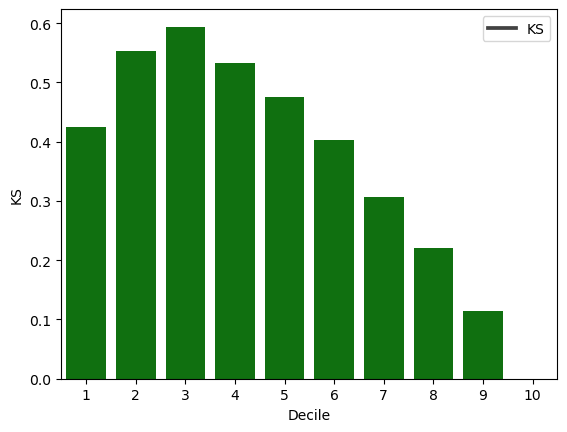

In [176]:
is_ks_maxed = sea.barplot(x = 'Decile', y = 'KS', data = ranked_dataFrame, color = 'green')
is_ks_maxed.legend(['KS'])